## LOADING LIBRARIES

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

## SPECIFY THE PATH OF DATA

In [3]:
imagePaths = list(paths.list_images("dataset")) 
data = []
labels = []

## LOADING THE DATA

In [4]:
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)


E:\anaconda\envs\datasci\lib\site-packages\PIL\Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


## ENCODING THE LABEL FROM STRINGS TO INTEGERS

In [5]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

## SPLITTING THE DATA INTO TRAINING AND TESTING 

In [6]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

## IMPLEMENT DATA AUGMENTATION

In [7]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")


## IMPORTING THE PRETRAINED ARCHITECTURE

In [8]:
baseModel = MobileNet(weights="imagenet", include_top=False,input_shape=(224, 224, 3))

In [9]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [10]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [11]:
for layer in baseModel.layers: #Untrained the trainable parameters to untrain because to train the parameters on our data.
	layer.trainable = False

In [12]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

## TRAINING THE MODEL

In [13]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)


[INFO] training head...
  ...
    to  
  ['...']
Train for 113 steps, validate on 905 samples
Epoch 1/20
113/113 [==============================] - 117s 1s/step - loss: 0.4982 - accuracy: 0.7732 - val_loss: 0.2632 - val_accuracy: 0.9051
Epoch 2/20
113/113 [==============================] - 86s 764ms/step - loss: 0.2206 - accuracy: 0.9222 - val_loss: 0.1688 - val_accuracy: 0.9364
Epoch 3/20
113/113 [==============================] - 87s 772ms/step - loss: 0.1595 - accuracy: 0.9386 - val_loss: 0.1061 - val_accuracy: 0.9621
Epoch 4/20
113/113 [==============================] - 87s 766ms/step - loss: 0.1395 - accuracy: 0.9453 - val_loss: 0.1857 - val_accuracy: 0.9208
Epoch 5/20
113/113 [==============================] - 86s 762ms/step - loss: 0.1265 - accuracy: 0.9576 - val_loss: 0.1827 - val_accuracy: 0.9241
Epoch 6/20
113/113 [==============================] - 87s 770ms/step - loss: 0.1116 - accuracy: 0.9665 - val_loss: 0.2035 - val_accuracy: 0.9129
Epoch 7/20
113/113 [==================

## SAVE THE MODEL AND USE IT IN FACE-MASK-DECTECTOR

In [14]:
model.save('pretrained model.h5') #SAVE THE MODEL

In [15]:
predIdxs = model.predict(testX, batch_size=BS)

In [16]:
predIdxs = np.argmax(predIdxs, axis=1)

In [17]:
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       1.00      0.93      0.96       521
without_mask       0.91      1.00      0.95       384

    accuracy                           0.96       905
   macro avg       0.95      0.96      0.96       905
weighted avg       0.96      0.96      0.96       905



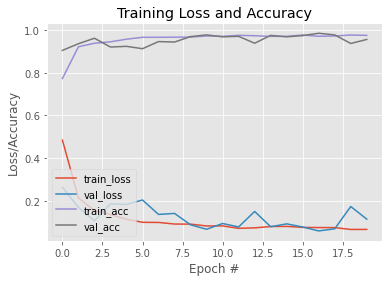

In [18]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

## U CAN USE ANY ARCHITECTURE TO TRAIN BUT MAKE SURE OF GOOD ACCURACY.